## Prediction with Bidirectional lstm with tuning parameter 

## Tuning parameter 1


In [1]:
#import library 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from tensorflow.keras.optimizers import Adam
print('Done')


#Panggil dataset 
trip1 = pd.read_csv('train.csv')

#ambil 1500 data saja
#trip1 = trip1.iloc[:7000]
trip1 = trip1.iloc[:10000]
trip1


#ambil kolom trip duration 
# Mengubah pickup_datetime menjadi hanya tanggal
trip1['pickup_datetime'] = pd.to_datetime(trip1['pickup_datetime']).dt.date

# Memilih kolom pickup_datetime dan trip_duration
#trip = trip[['pickup_datetime', 'trip_duration']]

trip1 = trip1[['trip_duration']]

# Menampilkan hasil
trip1

Done


,trip_duration
0,455
1,663
2,2124
3,429
4,435
...,...
9995,971
9996,932
9997,372
9998,295


In [2]:
#Preprocessing Data 
#Memeriksa nilai null 
print(trip1.isnull().sum())

trip_duration    0
dtype: int64


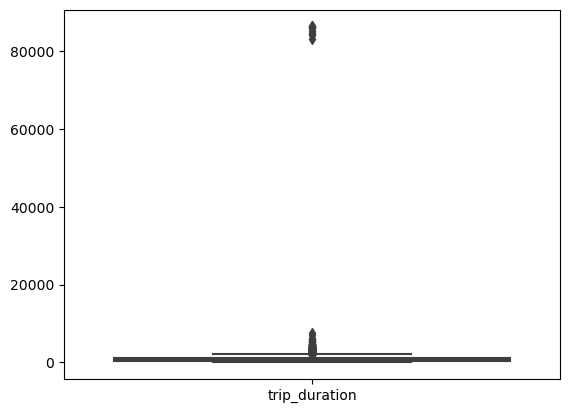

In [3]:
#Memeriksa outlier 
#import seaborn as sns

#trip[['trip_duration']] = trip
#sns.boxplot(data=trip[['trip_duration']])

import seaborn as sns
import matplotlib.pyplot as plt

# Membuat boxplot untuk memeriksa outlier
sns.boxplot(data=trip1[['trip_duration']])

# Menampilkan plot
plt.show()

In [4]:
#Menggunakan metode IQR (Interquartile Range) untuk menangani: 
Q1 = trip1['trip_duration'].quantile(0.25)
Q3 = trip1['trip_duration'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
trip1 = trip1[(trip1['trip_duration'] >= lower_bound) & (trip1['trip_duration'] <= upper_bound)]
trip1

,trip_duration
0,455
1,663
3,429
4,435
5,443
...,...
9995,971
9996,932
9997,372
9998,295


<Axes: >

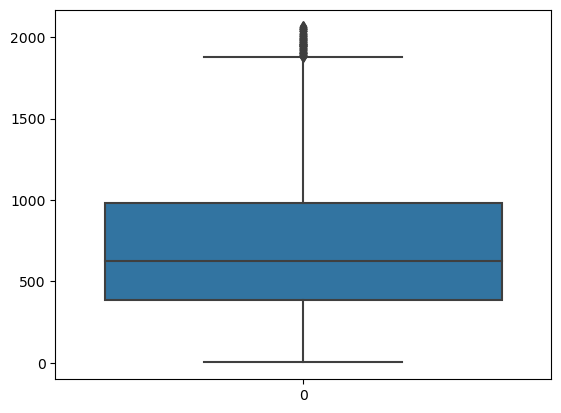

In [5]:
sns.boxplot(data=trip1['trip_duration'])

<Axes: >

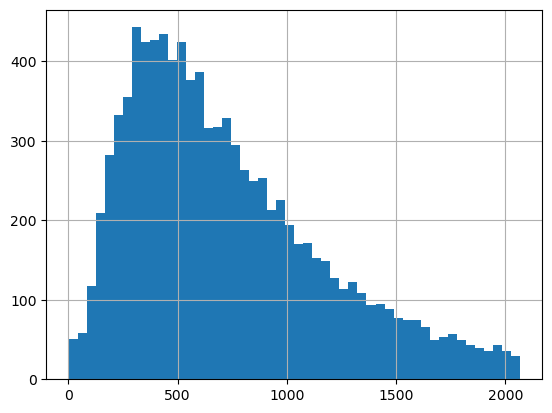

In [6]:
#Distribusi data 
trip1['trip_duration'].hist(bins=50)

In [7]:
#Q1 = trip['trip_duration'].quantile(0.25)
#Q3 = trip['trip_duration'].quantile(0.75)
#IQR = Q3 - Q1
#lower_bound = Q1 - 1.5 * IQR
#upper_bound = Q3 + 1.5 * IQR
#tripa = trip[(trip['trip_duration'] >= lower_bound) & (trip['trip_duration'] <= upper_bound)]
#tripa

# Menghitung kuartil pertama (Q1) dan kuartil ketiga (Q3)
Q1 = trip1['trip_duration'].quantile(0.25)
Q3 = trip1['trip_duration'].quantile(0.75)

# Menghitung IQR
IQR = Q3 - Q1

# Menentukan batas bawah dan batas atas untuk deteksi outlier
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Menyaring data berdasarkan batas bawah dan batas atas (menghapus outlier)
tripa1 = trip1[(trip1['trip_duration'] >= lower_bound) & (trip1['trip_duration'] <= upper_bound)]


#outliers = trip1[(trip['trip_duration'] < lower_bound) | (trip1['trip_duration'] > upper_bound)]
#print("Data Outlier:")
#print(outliers)

# Menampilkan data yang sudah disaring
print(tripa1)


# Menampilkan hasil outlier


# Jika ingin melihat jumlah outliers
#print(f"Jumlah outliers: {outliers.shape[0]}")

      trip_duration
0               455
1               663
3               429
4               435
5               443
...             ...
9995            971
9996            932
9997            372
9998            295
9999            619

[9337 rows x 1 columns]


array([[<Axes: title={'center': 'trip_duration'}>]], dtype=object)

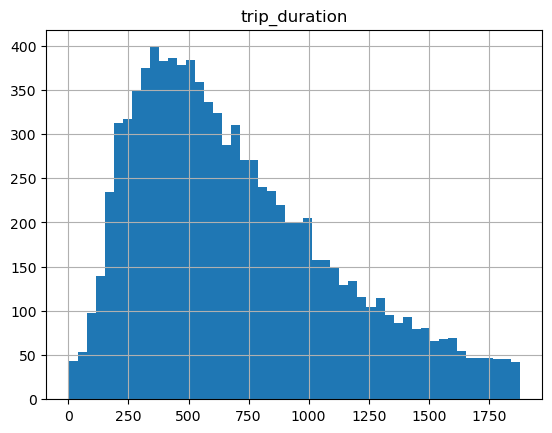

In [8]:
tripa1.hist(bins=50)

<Axes: >

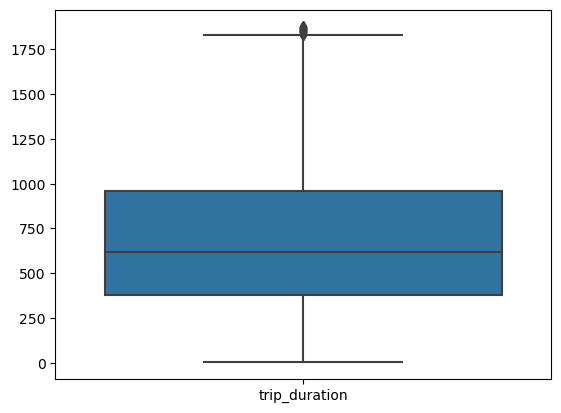

In [9]:
sns.boxplot(data=tripa1)

In [10]:
tripa1

,trip_duration
0,455
1,663
3,429
4,435
5,443
...,...
9995,971
9996,932
9997,372
9998,295


In [11]:
#ambil 1500 data saja
#tripa1 = tripa1.iloc[:7000]
#tripa  = tripa1
tripa = tripa1
tripa

,trip_duration
0,455
1,663
3,429
4,435
5,443
...,...
9995,971
9996,932
9997,372
9998,295


In [12]:
#Preprocessing Data 
#memeriksa nilai null 
tripa.isnull().sum()

trip_duration    0
dtype: int64

In [13]:
#Membagi data menjadi data training dan testing 
tripa = tripa
dataa = tripa.values 
#mebentuk kembali data 
dataa = dataa.reshape(-1,1)
data = dataa
data

array([[455],
       [663],
       [429],
       ...,
       [372],
       [295],
       [619]], dtype=int64)

In [14]:
#Membagi dataset menjadi training (75%) dan testing (25%)
percent_train = 0.75
trainingset = data[:int(len(data)*percent_train), :]
testset = data[int(len(data)*percent_train):, :]

# Menampilkan panjang data training dan testing
print("Panjang Training set:", len(trainingset))
print("Panjang Testing Set:", len(testset))

Panjang Training set: 7002
Panjang Testing Set: 2335


In [15]:
#Normalisasi data (mengubah data dari rentang 0 sampai dengan 1)
from sklearn.preprocessing import MinMaxScaler
tc = MinMaxScaler()
trainingset = tc.fit_transform(trainingset)
testset = tc.transform(testset)  # hanya transform, bukan fit_transform pada data testing
#testset   = tc.transform(testset)
print(trainingset)

[[0.24134257]
 [0.3521577 ]
 [0.22749068]
 ...
 [0.83750666]
 [0.12679808]
 [0.36441129]]


In [16]:
# Membuat dataset dengan window tertentu
def createDataset(data, window):
    dataX, dataY = [], []
    for i in range(len(data)-window):
        temp = []
        for j in range(i, i+window):
            temp.append(data[j, 0])
        dataX.append(temp)
        dataY.append(data[i+window, 0])
    return np.array(dataX), np.array(dataY)

window = 3
trainX, trainY = createDataset(trainingset, window)
testX, testY = createDataset(testset, window)  # Membuat data untuk testing
trainX = trainX.reshape(len(trainX), window, 1)  # reshape to 3D untuk LSTM
testX = testX.reshape(len(testX), window, 1)  # reshape to 3D untuk LSTM

print(trainX)
print(trainY)
print('Done')

[[[0.24134257]
  [0.3521577 ]
  [0.22749068]]

 [[0.3521577 ]
  [0.22749068]
  [0.23068727]]

 [[0.22749068]
  [0.23068727]
  [0.23494939]]

 ...

 [[0.15769845]
  [0.22802344]
  [0.31220032]]

 [[0.22802344]
  [0.31220032]
  [0.83750666]]

 [[0.31220032]
  [0.83750666]
  [0.12679808]]]
[0.23068727 0.23494939 0.18060735 ... 0.83750666 0.12679808 0.36441129]
Done


In [17]:
import tensorflow as tf
import tensorflow_estimator
import keras
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Bidirectional 
from tensorflow.keras.layers import LSTM
from sklearn.model_selection import train_test_split

print("jalan")

jalan


Epoch 1/2000
219/219 [==============================] - 22s 16ms/step - loss: 0.0549
Epoch 2/2000
219/219 [==============================] - 2s 11ms/step - loss: 0.0498
Epoch 3/2000
219/219 [==============================] - 2s 11ms/step - loss: 0.0497
Epoch 4/2000
219/219 [==============================] - 2s 11ms/step - loss: 0.0495
Epoch 5/2000
219/219 [==============================] - 2s 11ms/step - loss: 0.0498
Epoch 6/2000
219/219 [==============================] - 2s 11ms/step - loss: 0.0496
Epoch 7/2000
219/219 [==============================] - 2s 10ms/step - loss: 0.0494
Epoch 8/2000
219/219 [==============================] - 2s 10ms/step - loss: 0.0496
Epoch 9/2000
219/219 [==============================] - 2s 10ms/step - loss: 0.0496
Epoch 10/2000
219/219 [==============================] - 2s 10ms/step - loss: 0.0495
Epoch 11/2000
219/219 [==============================] - 2s 11ms/step - loss: 0.0493
Epoch 12/2000
219/219 [==============================] - 3s 12ms/step - l

219/219 [==============================] - 3s 13ms/step - loss: 0.0490
Epoch 193/2000
219/219 [==============================] - 3s 13ms/step - loss: 0.0490
Epoch 194/2000
219/219 [==============================] - 3s 12ms/step - loss: 0.0490
Epoch 195/2000
219/219 [==============================] - 3s 12ms/step - loss: 0.0489
Epoch 196/2000
219/219 [==============================] - 3s 12ms/step - loss: 0.0490
Epoch 197/2000
219/219 [==============================] - 3s 13ms/step - loss: 0.0490
Epoch 198/2000
219/219 [==============================] - 3s 13ms/step - loss: 0.0490
Epoch 199/2000
219/219 [==============================] - 3s 13ms/step - loss: 0.0490
Epoch 200/2000
219/219 [==============================] - 3s 12ms/step - loss: 0.0490
Epoch 201/2000
219/219 [==============================] - 3s 12ms/step - loss: 0.0490
Epoch 202/2000
219/219 [==============================] - 3s 14ms/step - loss: 0.0490
Epoch 203/2000
219/219 [==============================] - 3s 13ms/ste

219/219 [==============================] - 3s 16ms/step - loss: 0.0486
Epoch 383/2000
219/219 [==============================] - 3s 15ms/step - loss: 0.0486
Epoch 384/2000
219/219 [==============================] - 3s 14ms/step - loss: 0.0486
Epoch 385/2000
219/219 [==============================] - 3s 16ms/step - loss: 0.0487
Epoch 386/2000
219/219 [==============================] - 3s 15ms/step - loss: 0.0486
Epoch 387/2000
219/219 [==============================] - 3s 16ms/step - loss: 0.0486
Epoch 388/2000
219/219 [==============================] - 3s 15ms/step - loss: 0.0487
Epoch 389/2000
219/219 [==============================] - 3s 13ms/step - loss: 0.0486
Epoch 390/2000
219/219 [==============================] - 3s 13ms/step - loss: 0.0486
Epoch 391/2000
219/219 [==============================] - 3s 13ms/step - loss: 0.0486
Epoch 392/2000
219/219 [==============================] - 3s 14ms/step - loss: 0.0486
Epoch 393/2000
219/219 [==============================] - 3s 14ms/ste

219/219 [==============================] - 3s 14ms/step - loss: 0.0466
Epoch 573/2000
219/219 [==============================] - 3s 14ms/step - loss: 0.0468
Epoch 574/2000
219/219 [==============================] - 3s 13ms/step - loss: 0.0464
Epoch 575/2000
219/219 [==============================] - 3s 13ms/step - loss: 0.0467
Epoch 576/2000
219/219 [==============================] - 3s 12ms/step - loss: 0.0464
Epoch 577/2000
219/219 [==============================] - 3s 12ms/step - loss: 0.0465
Epoch 578/2000
219/219 [==============================] - 3s 14ms/step - loss: 0.0468
Epoch 579/2000
219/219 [==============================] - 3s 13ms/step - loss: 0.0465
Epoch 580/2000
219/219 [==============================] - 3s 12ms/step - loss: 0.0464
Epoch 581/2000
219/219 [==============================] - 3s 12ms/step - loss: 0.0466
Epoch 582/2000
219/219 [==============================] - 3s 12ms/step - loss: 0.0468
Epoch 583/2000
219/219 [==============================] - 3s 12ms/ste

219/219 [==============================] - 3s 13ms/step - loss: 0.0431
Epoch 763/2000
219/219 [==============================] - 3s 13ms/step - loss: 0.0429
Epoch 764/2000
219/219 [==============================] - 3s 13ms/step - loss: 0.0430
Epoch 765/2000
219/219 [==============================] - 3s 13ms/step - loss: 0.0429
Epoch 766/2000
219/219 [==============================] - 4s 16ms/step - loss: 0.0427
Epoch 767/2000
219/219 [==============================] - 3s 14ms/step - loss: 0.0426
Epoch 768/2000
219/219 [==============================] - 3s 13ms/step - loss: 0.0427
Epoch 769/2000
219/219 [==============================] - 3s 13ms/step - loss: 0.0425
Epoch 770/2000
219/219 [==============================] - 3s 13ms/step - loss: 0.0426
Epoch 771/2000
219/219 [==============================] - 3s 14ms/step - loss: 0.0427
Epoch 772/2000
219/219 [==============================] - 3s 14ms/step - loss: 0.0430
Epoch 773/2000
219/219 [==============================] - 3s 13ms/ste

219/219 [==============================] - 3s 13ms/step - loss: 0.0397
Epoch 953/2000
219/219 [==============================] - 3s 15ms/step - loss: 0.0393
Epoch 954/2000
219/219 [==============================] - 3s 16ms/step - loss: 0.0398
Epoch 955/2000
219/219 [==============================] - 3s 15ms/step - loss: 0.0395
Epoch 956/2000
219/219 [==============================] - 3s 15ms/step - loss: 0.0397
Epoch 957/2000
219/219 [==============================] - 3s 14ms/step - loss: 0.0398
Epoch 958/2000
219/219 [==============================] - 3s 15ms/step - loss: 0.0392
Epoch 959/2000
219/219 [==============================] - 3s 14ms/step - loss: 0.0399
Epoch 960/2000
219/219 [==============================] - 3s 13ms/step - loss: 0.0394
Epoch 961/2000
219/219 [==============================] - 3s 13ms/step - loss: 0.0403
Epoch 962/2000
219/219 [==============================] - 3s 13ms/step - loss: 0.0392
Epoch 963/2000
219/219 [==============================] - 3s 12ms/ste

219/219 [==============================] - 3s 13ms/step - loss: 0.0372
Epoch 1141/2000
219/219 [==============================] - 3s 13ms/step - loss: 0.0372
Epoch 1142/2000
219/219 [==============================] - 3s 13ms/step - loss: 0.0373
Epoch 1143/2000
219/219 [==============================] - 3s 13ms/step - loss: 0.0373
Epoch 1144/2000
219/219 [==============================] - 3s 14ms/step - loss: 0.0377
Epoch 1145/2000
219/219 [==============================] - 3s 14ms/step - loss: 0.0373
Epoch 1146/2000
219/219 [==============================] - 3s 13ms/step - loss: 0.0374
Epoch 1147/2000
219/219 [==============================] - 3s 13ms/step - loss: 0.0377
Epoch 1148/2000
219/219 [==============================] - 3s 13ms/step - loss: 0.0375
Epoch 1149/2000
219/219 [==============================] - 3s 14ms/step - loss: 0.0367
Epoch 1150/2000
219/219 [==============================] - 3s 14ms/step - loss: 0.0379
Epoch 1151/2000
219/219 [==============================] - 

219/219 [==============================] - 3s 14ms/step - loss: 0.0354
Epoch 1329/2000
219/219 [==============================] - 3s 14ms/step - loss: 0.0357
Epoch 1330/2000
219/219 [==============================] - 3s 13ms/step - loss: 0.0348
Epoch 1331/2000
219/219 [==============================] - 3s 13ms/step - loss: 0.0354
Epoch 1332/2000
219/219 [==============================] - 3s 13ms/step - loss: 0.0359
Epoch 1333/2000
219/219 [==============================] - 3s 12ms/step - loss: 0.0357
Epoch 1334/2000
219/219 [==============================] - 3s 14ms/step - loss: 0.0357
Epoch 1335/2000
219/219 [==============================] - 3s 14ms/step - loss: 0.0364
Epoch 1336/2000
219/219 [==============================] - 3s 12ms/step - loss: 0.0351
Epoch 1337/2000
219/219 [==============================] - 3s 12ms/step - loss: 0.0355
Epoch 1338/2000
219/219 [==============================] - 3s 12ms/step - loss: 0.0353
Epoch 1339/2000
219/219 [==============================] - 

219/219 [==============================] - 3s 12ms/step - loss: 0.0339
Epoch 1517/2000
219/219 [==============================] - 3s 13ms/step - loss: 0.0340
Epoch 1518/2000
219/219 [==============================] - 3s 13ms/step - loss: 0.0341
Epoch 1519/2000
219/219 [==============================] - 3s 14ms/step - loss: 0.0338
Epoch 1520/2000
219/219 [==============================] - 3s 14ms/step - loss: 0.0341
Epoch 1521/2000
219/219 [==============================] - 3s 13ms/step - loss: 0.0337
Epoch 1522/2000
219/219 [==============================] - 3s 13ms/step - loss: 0.0334
Epoch 1523/2000
219/219 [==============================] - 3s 13ms/step - loss: 0.0338
Epoch 1524/2000
219/219 [==============================] - 3s 14ms/step - loss: 0.0341
Epoch 1525/2000
219/219 [==============================] - 3s 14ms/step - loss: 0.0332
Epoch 1526/2000
219/219 [==============================] - 3s 13ms/step - loss: 0.0343
Epoch 1527/2000
219/219 [==============================] - 

219/219 [==============================] - 4s 16ms/step - loss: 0.0323
Epoch 1705/2000
219/219 [==============================] - 5s 22ms/step - loss: 0.0322
Epoch 1706/2000
219/219 [==============================] - 4s 16ms/step - loss: 0.0322
Epoch 1707/2000
219/219 [==============================] - 3s 16ms/step - loss: 0.0324
Epoch 1708/2000
219/219 [==============================] - 3s 15ms/step - loss: 0.0324
Epoch 1709/2000
219/219 [==============================] - 3s 16ms/step - loss: 0.0320
Epoch 1710/2000
219/219 [==============================] - 5s 21ms/step - loss: 0.0325
Epoch 1711/2000
219/219 [==============================] - 3s 16ms/step - loss: 0.0324
Epoch 1712/2000
219/219 [==============================] - 3s 13ms/step - loss: 0.0320
Epoch 1713/2000
219/219 [==============================] - 3s 13ms/step - loss: 0.0325
Epoch 1714/2000
219/219 [==============================] - 3s 15ms/step - loss: 0.0316
Epoch 1715/2000
219/219 [==============================] - 

219/219 [==============================] - 3s 13ms/step - loss: 0.0305
Epoch 1893/2000
219/219 [==============================] - 3s 13ms/step - loss: 0.0309
Epoch 1894/2000
219/219 [==============================] - 3s 14ms/step - loss: 0.0302
Epoch 1895/2000
219/219 [==============================] - 3s 15ms/step - loss: 0.0310
Epoch 1896/2000
219/219 [==============================] - 3s 13ms/step - loss: 0.0306
Epoch 1897/2000
219/219 [==============================] - 3s 13ms/step - loss: 0.0317
Epoch 1898/2000
219/219 [==============================] - 3s 13ms/step - loss: 0.0310
Epoch 1899/2000
219/219 [==============================] - 3s 14ms/step - loss: 0.0313
Epoch 1900/2000
219/219 [==============================] - 3s 14ms/step - loss: 0.0310
Epoch 1901/2000
219/219 [==============================] - 3s 14ms/step - loss: 0.0312
Epoch 1902/2000
219/219 [==============================] - 3s 13ms/step - loss: 0.0313
Epoch 1903/2000
219/219 [==============================] - 

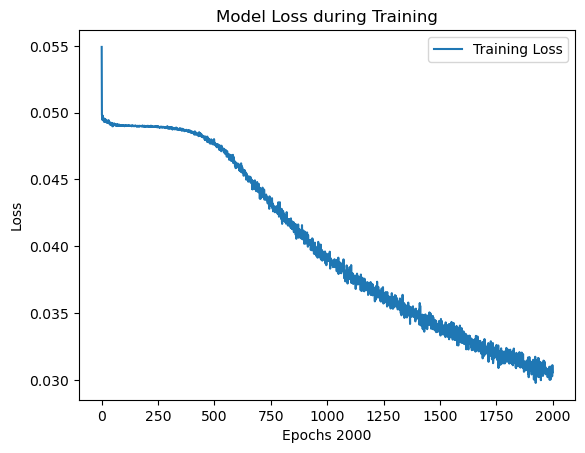

In [18]:
#masuk kedalam model bidirectional LSTM 
#model 

#Membagi data pelatihan menjadi data training dan validation
#trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size=0.2, random_state=42)

# Model
regressor = Sequential()

# Menambahkan layer Bidirectional LSTM dengan Dropout
regressor.add(Bidirectional(LSTM(units=50, activation='tanh', return_sequences=True, input_shape=(trainX.shape[1], 1))))
regressor.add(Dropout(0.2))  # Menambahkan dropout 30%

regressor.add(Bidirectional(LSTM(units=50, return_sequences=True)))
regressor.add(Dropout(0.2))  # Menambahkan dropout 30%

regressor.add(Bidirectional(LSTM(units=50, return_sequences=True)))
regressor.add(Dropout(0.2))  # Menambahkan dropout 30%

regressor.add(Bidirectional(LSTM(units=50)))
regressor.add(Dropout(0.2))  # Menambahkan dropout 30%

# Output layer
regressor.add(Dense(units=1))

# Compile model
regressor.compile(optimizer='adam', loss='mean_squared_error')

# Fit model with validation data and store the history
history = regressor.fit(trainX, trainY, epochs=2000, batch_size=32) #, validation_data=(testX, testY)

# Plot the loss function (training loss and validation loss)
plt.plot(history.history['loss'], label='Training Loss')
#plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss during Training')
plt.xlabel('Epochs 2000')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
testX, testY = createDataset(testset, window)   #split x and y
testX=testX.reshape(len(testset)-window,window,1)   #reshape x to 3D
print('Done')

Done


In [20]:
predict_price = regressor.predict(testX)
print('Done')

73/73 [==============================] - 7s 8ms/step
Done


In [21]:
# Menghitung RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(testY.flatten(), predict_price.flatten()))
print(f"RMSE: {rmse}")

RMSE: 0.26909194486620847


In [22]:
testY=tc.inverse_transform(testY.reshape(-1,1))
predict_price=tc.inverse_transform(predict_price)
trainingset=tc.inverse_transform(trainingset)
testset=tc.inverse_transform(testset)
dfpredict=pd.DataFrame(dict(testY=list(testY),predict=list(predict_price)))
print(dfpredict)

def dstat(x,y):
    dstat = 0
    n = len(y)
    for i in range(n-1):
        if ((x[i+1]-y[i])*(y[i+1]-y[i]))>0 :
            dstat += 1
            Dstat = (float(1/(n-1))*dstat)*100
    return float(Dstat)

print('Dstat = {}%'.format(dstat(testY,predict_price)))

                     testY      predict
0                  [857.0]  [491.97147]
1     [497.00000000000006]   [732.3309]
2                  [618.0]   [540.6751]
3                  [527.0]   [903.9641]
4                  [357.0]   [697.3037]
...                    ...          ...
2327   [970.9999999999999]   [562.0149]
2328               [932.0]  [942.29364]
2329               [372.0]   [677.6985]
2330               [295.0]   [611.8963]
2331               [619.0]   [581.6391]

[2332 rows x 2 columns]
Dstat = 59.631059631059635%


In [ ]:
import matplotlib.pyplot as plt

# Plot hasil prediksi vs nilai sebenarnya
plt.figure(figsize=(12, 6))

# Plot nilai sebenarnya
plt.plot(testY, label='Nilai Sebenarnya', color='blue')

# Plot nilai prediksi
plt.plot(predict_price, label='Nilai Prediksi', color='orange')

# Menambahkan detail plot
plt.title('Perbandingan nilai prediksi dan sebenarnya (Epoch 300)', fontsize=16)
plt.xlabel('Index', fontsize=14)
plt.ylabel('Trip Duration', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Menampilkan plot
plt.show()

## Tuning parameter 2

In [199]:
#import library 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from tensorflow.keras.optimizers import Adam
print('Done')


#Panggil dataset 
trip1 = pd.read_csv('train.csv')

#ambil 1500 data saja
#trip1 = trip1.iloc[:7000]
trip1 = trip1.iloc[:10000]
trip1


#ambil kolom trip duration 
# Mengubah pickup_datetime menjadi hanya tanggal
trip1['pickup_datetime'] = pd.to_datetime(trip1['pickup_datetime']).dt.date

# Memilih kolom pickup_datetime dan trip_duration
#trip = trip[['pickup_datetime', 'trip_duration']]

trip1 = trip1[['trip_duration']]

# Menampilkan hasil
trip1

Done


,trip_duration
0,455
1,663
2,2124
3,429
4,435
...,...
9995,971
9996,932
9997,372
9998,295


In [200]:
#Preprocessing Data 
#Memeriksa nilai null 
print(trip1.isnull().sum())

trip_duration    0
dtype: int64


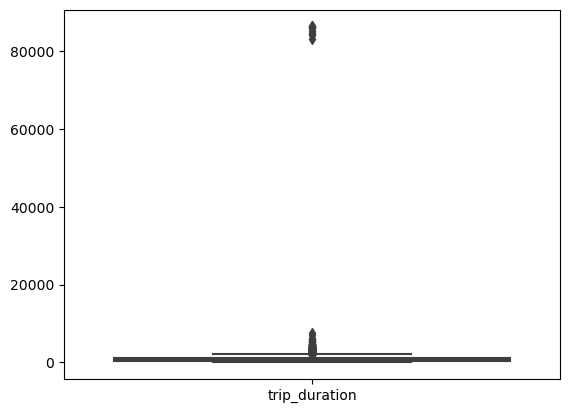

In [201]:
#Memeriksa outlier 
#import seaborn as sns

#trip[['trip_duration']] = trip
#sns.boxplot(data=trip[['trip_duration']])

import seaborn as sns
import matplotlib.pyplot as plt

# Membuat boxplot untuk memeriksa outlier
sns.boxplot(data=trip1[['trip_duration']])

# Menampilkan plot
plt.show()

In [202]:
#Menggunakan metode IQR (Interquartile Range) untuk menangani: 
Q1 = trip1['trip_duration'].quantile(0.25)
Q3 = trip1['trip_duration'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
trip1 = trip1[(trip1['trip_duration'] >= lower_bound) & (trip1['trip_duration'] <= upper_bound)]
trip1

,trip_duration
0,455
1,663
3,429
4,435
5,443
...,...
9995,971
9996,932
9997,372
9998,295


<Axes: >

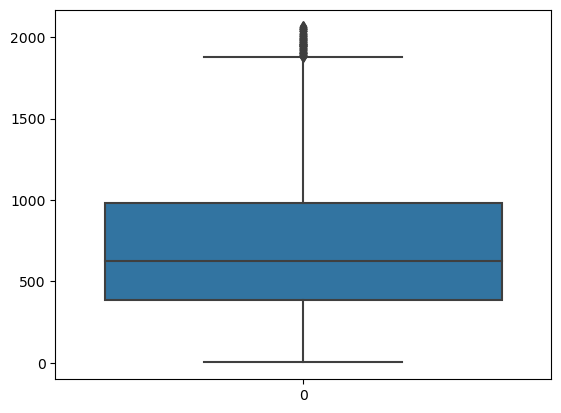

In [203]:
sns.boxplot(data=trip1['trip_duration'])

<Axes: >

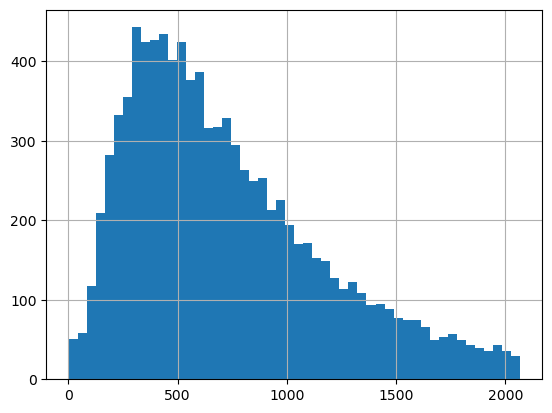

In [204]:
#Distribusi data 
trip1['trip_duration'].hist(bins=50)

In [205]:
#Q1 = trip['trip_duration'].quantile(0.25)
#Q3 = trip['trip_duration'].quantile(0.75)
#IQR = Q3 - Q1
#lower_bound = Q1 - 1.5 * IQR
#upper_bound = Q3 + 1.5 * IQR
#tripa = trip[(trip['trip_duration'] >= lower_bound) & (trip['trip_duration'] <= upper_bound)]
#tripa

# Menghitung kuartil pertama (Q1) dan kuartil ketiga (Q3)
Q1 = trip1['trip_duration'].quantile(0.25)
Q3 = trip1['trip_duration'].quantile(0.75)

# Menghitung IQR
IQR = Q3 - Q1

# Menentukan batas bawah dan batas atas untuk deteksi outlier
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Menyaring data berdasarkan batas bawah dan batas atas (menghapus outlier)
tripa1 = trip1[(trip1['trip_duration'] >= lower_bound) & (trip1['trip_duration'] <= upper_bound)]


#outliers = trip1[(trip['trip_duration'] < lower_bound) | (trip1['trip_duration'] > upper_bound)]
#print("Data Outlier:")
#print(outliers)

# Menampilkan data yang sudah disaring
print(tripa1)


# Menampilkan hasil outlier


# Jika ingin melihat jumlah outliers
#print(f"Jumlah outliers: {outliers.shape[0]}")

      trip_duration
0               455
1               663
3               429
4               435
5               443
...             ...
9995            971
9996            932
9997            372
9998            295
9999            619

[9337 rows x 1 columns]


array([[<Axes: title={'center': 'trip_duration'}>]], dtype=object)

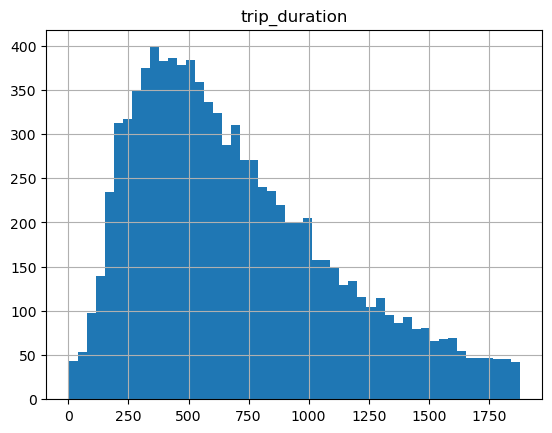

In [206]:
tripa1.hist(bins=50)

<Axes: >

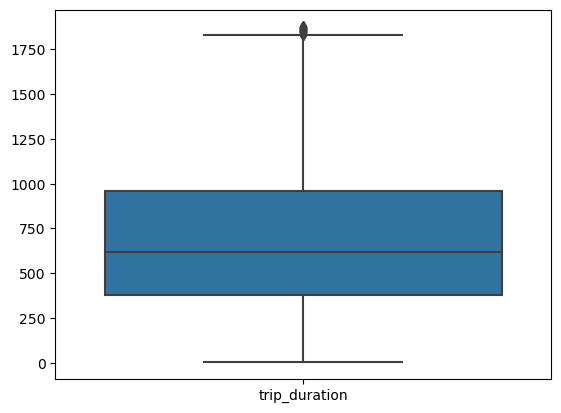

In [207]:
sns.boxplot(data=tripa1)

In [208]:
tripa1

,trip_duration
0,455
1,663
3,429
4,435
5,443
...,...
9995,971
9996,932
9997,372
9998,295


In [209]:
#ambil 1500 data saja
#tripa1 = tripa1.iloc[:7000]
#tripa  = tripa1
tripa = tripa1
tripa

,trip_duration
0,455
1,663
3,429
4,435
5,443
...,...
9995,971
9996,932
9997,372
9998,295


In [210]:
#Preprocessing Data 
#memeriksa nilai null 
tripa.isnull().sum()

trip_duration    0
dtype: int64

In [211]:
#Membagi data menjadi data training dan testing 
tripa = tripa
dataa = tripa.values 
#mebentuk kembali data 
dataa = dataa.reshape(-1,1)
data = dataa
data

array([[455],
       [663],
       [429],
       ...,
       [372],
       [295],
       [619]], dtype=int64)

In [212]:
#Membagi dataset menjadi training (75%) dan testing (25%)
percent_train = 0.75
trainingset = data[:int(len(data)*percent_train), :]
testset = data[int(len(data)*percent_train):, :]

# Menampilkan panjang data training dan testing
print("Panjang Training set:", len(trainingset))
print("Panjang Testing Set:", len(testset))

Panjang Training set: 7002
Panjang Testing Set: 2335


In [213]:
#Normalisasi data (mengubah data dari rentang 0 sampai dengan 1)
from sklearn.preprocessing import MinMaxScaler
tc = MinMaxScaler()
trainingset = tc.fit_transform(trainingset)
testset = tc.transform(testset)  # hanya transform, bukan fit_transform pada data testing
#testset   = tc.transform(testset)
print(trainingset)

[[0.24134257]
 [0.3521577 ]
 [0.22749068]
 ...
 [0.83750666]
 [0.12679808]
 [0.36441129]]


In [214]:
# Membuat dataset dengan window tertentu
def createDataset(data, window):
    dataX, dataY = [], []
    for i in range(len(data)-window):
        temp = []
        for j in range(i, i+window):
            temp.append(data[j, 0])
        dataX.append(temp)
        dataY.append(data[i+window, 0])
    return np.array(dataX), np.array(dataY)

window = 3
trainX, trainY = createDataset(trainingset, window)
testX, testY = createDataset(testset, window)  # Membuat data untuk testing
trainX = trainX.reshape(len(trainX), window, 1)  # reshape to 3D untuk LSTM
testX = testX.reshape(len(testX), window, 1)  # reshape to 3D untuk LSTM

print(trainX)
print(trainY)
print('Done')

[[[0.24134257]
  [0.3521577 ]
  [0.22749068]]

 [[0.3521577 ]
  [0.22749068]
  [0.23068727]]

 [[0.22749068]
  [0.23068727]
  [0.23494939]]

 ...

 [[0.15769845]
  [0.22802344]
  [0.31220032]]

 [[0.22802344]
  [0.31220032]
  [0.83750666]]

 [[0.31220032]
  [0.83750666]
  [0.12679808]]]
[0.23068727 0.23494939 0.18060735 ... 0.83750666 0.12679808 0.36441129]
Done


Epoch 1/2000
110/110 [==============================] - 56s 55ms/step - loss: 0.0685
Epoch 2/2000
110/110 [==============================] - 6s 54ms/step - loss: 0.0492
Epoch 3/2000
110/110 [==============================] - 6s 56ms/step - loss: 0.0492
Epoch 4/2000
110/110 [==============================] - 6s 55ms/step - loss: 0.0491
Epoch 5/2000
110/110 [==============================] - 6s 54ms/step - loss: 0.0492
Epoch 6/2000
110/110 [==============================] - 6s 58ms/step - loss: 0.0492
Epoch 7/2000
110/110 [==============================] - 6s 54ms/step - loss: 0.0491
Epoch 8/2000
110/110 [==============================] - 7s 61ms/step - loss: 0.0492
Epoch 9/2000
110/110 [==============================] - 7s 61ms/step - loss: 0.0492
Epoch 10/2000
110/110 [==============================] - 6s 53ms/step - loss: 0.0492
Epoch 11/2000
110/110 [==============================] - 6s 54ms/step - loss: 0.0493
Epoch 12/2000
110/110 [==============================] - 6s 53ms/step - l

110/110 [==============================] - 6s 53ms/step - loss: 0.0490
Epoch 193/2000
110/110 [==============================] - 6s 52ms/step - loss: 0.0490
Epoch 194/2000
110/110 [==============================] - 6s 52ms/step - loss: 0.0490
Epoch 195/2000
110/110 [==============================] - 6s 52ms/step - loss: 0.0490
Epoch 196/2000
110/110 [==============================] - 6s 52ms/step - loss: 0.0490
Epoch 197/2000
110/110 [==============================] - 6s 52ms/step - loss: 0.0490
Epoch 198/2000
110/110 [==============================] - 6s 52ms/step - loss: 0.0490
Epoch 199/2000
110/110 [==============================] - 6s 55ms/step - loss: 0.0490
Epoch 200/2000
110/110 [==============================] - 6s 52ms/step - loss: 0.0491
Epoch 201/2000
110/110 [==============================] - 6s 52ms/step - loss: 0.0490
Epoch 202/2000
110/110 [==============================] - 6s 53ms/step - loss: 0.0490
Epoch 203/2000
110/110 [==============================] - 6s 51ms/ste

110/110 [==============================] - 6s 52ms/step - loss: 0.0490
Epoch 383/2000
110/110 [==============================] - 6s 52ms/step - loss: 0.0490
Epoch 384/2000
110/110 [==============================] - 6s 51ms/step - loss: 0.0490
Epoch 385/2000
110/110 [==============================] - 6s 52ms/step - loss: 0.0490
Epoch 386/2000
110/110 [==============================] - 6s 52ms/step - loss: 0.0490
Epoch 387/2000
110/110 [==============================] - 6s 52ms/step - loss: 0.0490
Epoch 388/2000
110/110 [==============================] - 6s 52ms/step - loss: 0.0490
Epoch 389/2000
110/110 [==============================] - 6s 52ms/step - loss: 0.0490
Epoch 390/2000
110/110 [==============================] - 6s 53ms/step - loss: 0.0490
Epoch 391/2000
110/110 [==============================] - 6s 52ms/step - loss: 0.0490
Epoch 392/2000
110/110 [==============================] - 6s 53ms/step - loss: 0.0490
Epoch 393/2000
110/110 [==============================] - 6s 53ms/ste

110/110 [==============================] - 4s 35ms/step - loss: 0.0490
Epoch 573/2000
110/110 [==============================] - 4s 35ms/step - loss: 0.0490
Epoch 574/2000
110/110 [==============================] - 3s 31ms/step - loss: 0.0490
Epoch 575/2000
110/110 [==============================] - 4s 32ms/step - loss: 0.0490
Epoch 576/2000
110/110 [==============================] - 4s 37ms/step - loss: 0.0490
Epoch 577/2000
110/110 [==============================] - 4s 35ms/step - loss: 0.0490
Epoch 578/2000
110/110 [==============================] - 4s 37ms/step - loss: 0.0490
Epoch 579/2000
110/110 [==============================] - 4s 35ms/step - loss: 0.0490
Epoch 580/2000
110/110 [==============================] - 4s 34ms/step - loss: 0.0490
Epoch 581/2000
110/110 [==============================] - 4s 39ms/step - loss: 0.0490
Epoch 582/2000
110/110 [==============================] - 6s 54ms/step - loss: 0.0490
Epoch 583/2000
110/110 [==============================] - 4s 39ms/ste

110/110 [==============================] - 3s 29ms/step - loss: 0.0490
Epoch 763/2000
110/110 [==============================] - 3s 30ms/step - loss: 0.0490
Epoch 764/2000
110/110 [==============================] - 4s 35ms/step - loss: 0.0490
Epoch 765/2000
110/110 [==============================] - 4s 33ms/step - loss: 0.0490
Epoch 766/2000
110/110 [==============================] - 3s 29ms/step - loss: 0.0490
Epoch 767/2000
110/110 [==============================] - 3s 29ms/step - loss: 0.0490
Epoch 768/2000
110/110 [==============================] - 4s 34ms/step - loss: 0.0490
Epoch 769/2000
110/110 [==============================] - 4s 34ms/step - loss: 0.0490
Epoch 770/2000
110/110 [==============================] - 3s 30ms/step - loss: 0.0490
Epoch 771/2000
110/110 [==============================] - 3s 28ms/step - loss: 0.0490
Epoch 772/2000
110/110 [==============================] - 3s 28ms/step - loss: 0.0490
Epoch 773/2000
110/110 [==============================] - 3s 30ms/ste

110/110 [==============================] - 3s 29ms/step - loss: 0.0490
Epoch 953/2000
110/110 [==============================] - 3s 27ms/step - loss: 0.0490
Epoch 954/2000
110/110 [==============================] - 3s 27ms/step - loss: 0.0490
Epoch 955/2000
110/110 [==============================] - 3s 29ms/step - loss: 0.0490
Epoch 956/2000
110/110 [==============================] - 3s 29ms/step - loss: 0.0490
Epoch 957/2000
110/110 [==============================] - 3s 30ms/step - loss: 0.0490
Epoch 958/2000
110/110 [==============================] - 3s 28ms/step - loss: 0.0490
Epoch 959/2000
110/110 [==============================] - 3s 28ms/step - loss: 0.0490
Epoch 960/2000
110/110 [==============================] - 3s 29ms/step - loss: 0.0490
Epoch 961/2000
110/110 [==============================] - 3s 31ms/step - loss: 0.0490
Epoch 962/2000
110/110 [==============================] - 3s 29ms/step - loss: 0.0490
Epoch 963/2000
110/110 [==============================] - 3s 27ms/ste

110/110 [==============================] - 3s 29ms/step - loss: 0.0490
Epoch 1141/2000
110/110 [==============================] - 3s 29ms/step - loss: 0.0490
Epoch 1142/2000
110/110 [==============================] - 3s 31ms/step - loss: 0.0490
Epoch 1143/2000
110/110 [==============================] - 3s 31ms/step - loss: 0.0490
Epoch 1144/2000
110/110 [==============================] - 3s 29ms/step - loss: 0.0490
Epoch 1145/2000
110/110 [==============================] - 3s 29ms/step - loss: 0.0490
Epoch 1146/2000
110/110 [==============================] - 3s 29ms/step - loss: 0.0490
Epoch 1147/2000
110/110 [==============================] - 3s 31ms/step - loss: 0.0490
Epoch 1148/2000
110/110 [==============================] - 3s 31ms/step - loss: 0.0490
Epoch 1149/2000
110/110 [==============================] - 3s 30ms/step - loss: 0.0490
Epoch 1150/2000
110/110 [==============================] - 3s 29ms/step - loss: 0.0490
Epoch 1151/2000
110/110 [==============================] - 

110/110 [==============================] - 4s 36ms/step - loss: 0.0490
Epoch 1329/2000
110/110 [==============================] - 4s 34ms/step - loss: 0.0490
Epoch 1330/2000
110/110 [==============================] - 4s 34ms/step - loss: 0.0490
Epoch 1331/2000
110/110 [==============================] - 4s 34ms/step - loss: 0.0490
Epoch 1332/2000
110/110 [==============================] - 4s 32ms/step - loss: 0.0490
Epoch 1333/2000
110/110 [==============================] - 3s 31ms/step - loss: 0.0490
Epoch 1334/2000
110/110 [==============================] - 4s 33ms/step - loss: 0.0490
Epoch 1335/2000
110/110 [==============================] - 4s 35ms/step - loss: 0.0490
Epoch 1336/2000
110/110 [==============================] - 3s 32ms/step - loss: 0.0490
Epoch 1337/2000
110/110 [==============================] - 4s 36ms/step - loss: 0.0490
Epoch 1338/2000
110/110 [==============================] - 4s 38ms/step - loss: 0.0490
Epoch 1339/2000
110/110 [==============================] - 

110/110 [==============================] - 4s 32ms/step - loss: 0.0490
Epoch 1517/2000
110/110 [==============================] - 3s 30ms/step - loss: 0.0490
Epoch 1518/2000
110/110 [==============================] - 3s 30ms/step - loss: 0.0490
Epoch 1519/2000
110/110 [==============================] - 3s 32ms/step - loss: 0.0490
Epoch 1520/2000
110/110 [==============================] - 4s 32ms/step - loss: 0.0490
Epoch 1521/2000
110/110 [==============================] - 3s 31ms/step - loss: 0.0490
Epoch 1522/2000
110/110 [==============================] - 3s 29ms/step - loss: 0.0490
Epoch 1523/2000
110/110 [==============================] - 3s 30ms/step - loss: 0.0490
Epoch 1524/2000
110/110 [==============================] - 4s 32ms/step - loss: 0.0490
Epoch 1525/2000
110/110 [==============================] - 4s 32ms/step - loss: 0.0490
Epoch 1526/2000
110/110 [==============================] - 3s 30ms/step - loss: 0.0490
Epoch 1527/2000
110/110 [==============================] - 

110/110 [==============================] - 3s 30ms/step - loss: 0.0490
Epoch 1705/2000
110/110 [==============================] - 3s 30ms/step - loss: 0.0490
Epoch 1706/2000
110/110 [==============================] - 4s 32ms/step - loss: 0.0490
Epoch 1707/2000
110/110 [==============================] - 4s 32ms/step - loss: 0.0490
Epoch 1708/2000
110/110 [==============================] - 3s 32ms/step - loss: 0.0490
Epoch 1709/2000
110/110 [==============================] - 3s 28ms/step - loss: 0.0490
Epoch 1710/2000
110/110 [==============================] - 3s 29ms/step - loss: 0.0490
Epoch 1711/2000
110/110 [==============================] - 3s 31ms/step - loss: 0.0490
Epoch 1712/2000
110/110 [==============================] - 3s 31ms/step - loss: 0.0490
Epoch 1713/2000
110/110 [==============================] - 3s 31ms/step - loss: 0.0490
Epoch 1714/2000
110/110 [==============================] - 3s 30ms/step - loss: 0.0490
Epoch 1715/2000
110/110 [==============================] - 

110/110 [==============================] - 4s 32ms/step - loss: 0.0490
Epoch 1893/2000
110/110 [==============================] - 4s 35ms/step - loss: 0.0490
Epoch 1894/2000
110/110 [==============================] - 4s 33ms/step - loss: 0.0490
Epoch 1895/2000
110/110 [==============================] - 3s 30ms/step - loss: 0.0490
Epoch 1896/2000
110/110 [==============================] - 3s 31ms/step - loss: 0.0490
Epoch 1897/2000
110/110 [==============================] - 4s 32ms/step - loss: 0.0490
Epoch 1898/2000
110/110 [==============================] - 3s 32ms/step - loss: 0.0490
Epoch 1899/2000
110/110 [==============================] - 3s 29ms/step - loss: 0.0490
Epoch 1900/2000
110/110 [==============================] - 3s 30ms/step - loss: 0.0490
Epoch 1901/2000
110/110 [==============================] - 4s 33ms/step - loss: 0.0490
Epoch 1902/2000
110/110 [==============================] - 4s 32ms/step - loss: 0.0490
Epoch 1903/2000
110/110 [==============================] - 

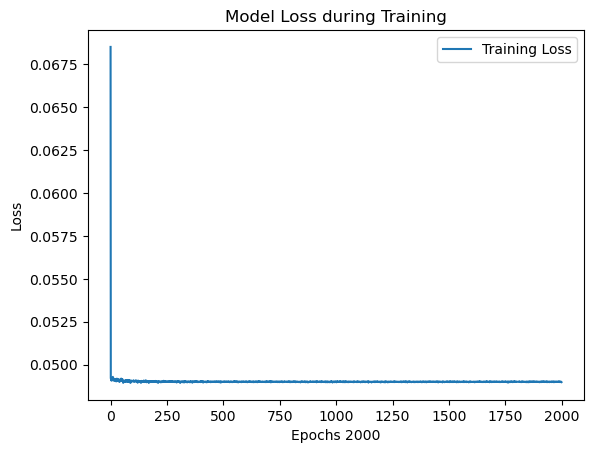

In [215]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.optimizers import SGD
import matplotlib.pyplot as plt

# Model
regressor = Sequential()

# Menambahkan 5 layer Bidirectional LSTM dengan Dropout 0.3
regressor.add(Bidirectional(LSTM(units=50, activation='tanh', return_sequences=True, input_shape=(trainX.shape[1], 1))))
regressor.add(Dropout(0.3))  # Menambahkan dropout 30%

regressor.add(Bidirectional(LSTM(units=50, return_sequences=True)))
regressor.add(Dropout(0.3))  # Menambahkan dropout 30%

regressor.add(Bidirectional(LSTM(units=50, return_sequences=True)))
regressor.add(Dropout(0.3))  # Menambahkan dropout 30%

regressor.add(Bidirectional(LSTM(units=50, return_sequences=True)))
regressor.add(Dropout(0.3))  # Menambahkan dropout 30%

regressor.add(Bidirectional(LSTM(units=50)))
regressor.add(Dropout(0.3))  # Menambahkan dropout 30%

# Output layer
regressor.add(Dense(units=1))

# Menggunakan SGD tanpa parameter tambahan
optimizer = SGD()

# Compile model dengan SGD optimizer
regressor.compile(optimizer=optimizer, loss='mean_squared_error')

# Fit model dengan validation data dan batch size 64
history = regressor.fit(trainX, trainY, epochs=2000, batch_size=64)

# Plot the loss function (training loss)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Loss during Training')
plt.xlabel('Epochs 2000')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [216]:
testX, testY = createDataset(testset, window)   #split x and y
testX=testX.reshape(len(testset)-window,window,1)   #reshape x to 3D
print('Done')

Done


In [217]:
predict_price = regressor.predict(testX)
print('Done')

73/73 [==============================] - 5s 6ms/step
Done


In [218]:
# Menghitung RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(testY.flatten(), predict_price.flatten()))
print(f"RMSE: {rmse}")

RMSE: 0.2220412396869462


In [219]:
testY=tc.inverse_transform(testY.reshape(-1,1))
predict_price=tc.inverse_transform(predict_price)
trainingset=tc.inverse_transform(trainingset)
testset=tc.inverse_transform(testset)
dfpredict=pd.DataFrame(dict(testY=list(testY),predict=list(predict_price)))
print(dfpredict)

def dstat(x,y):
    dstat = 0
    n = len(y)
    for i in range(n-1):
        if ((x[i+1]-y[i])*(y[i+1]-y[i]))>0 :
            dstat += 1
            Dstat = (float(1/(n-1))*dstat)*100
    return float(Dstat)

print('Dstat = {}%'.format(dstat(testY,predict_price)))


                     testY      predict
0                  [857.0]  [699.83234]
1     [497.00000000000006]  [699.91144]
2                  [618.0]  [700.11206]
3                  [527.0]  [700.10913]
4                  [357.0]   [700.1714]
...                    ...          ...
2327   [970.9999999999999]   [700.0271]
2328               [932.0]   [699.8081]
2329               [372.0]   [699.7181]
2330               [295.0]   [700.0595]
2331               [619.0]   [700.3623]

[2332 rows x 2 columns]
Dstat = 49.335049335049334%


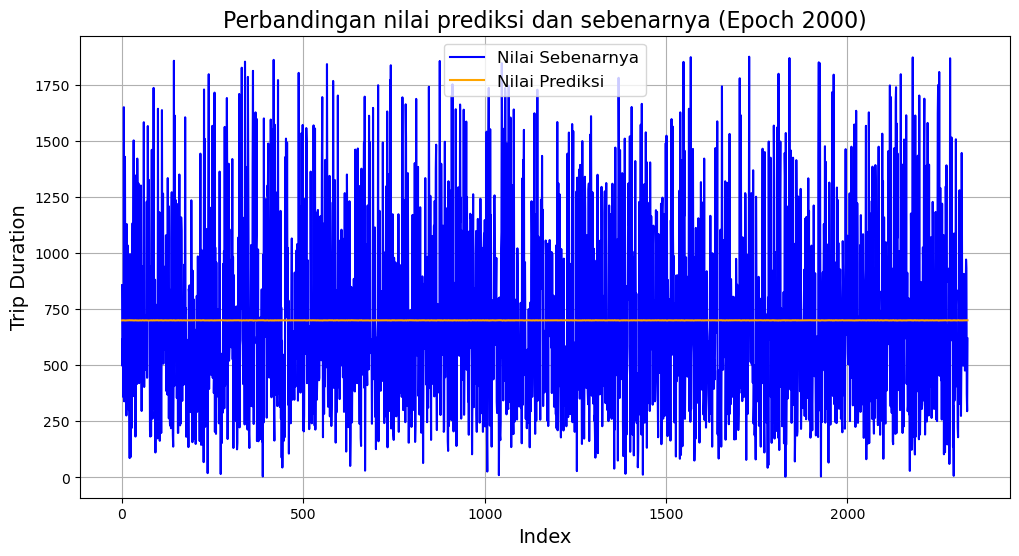

In [220]:

import matplotlib.pyplot as plt

# Plot hasil prediksi vs nilai sebenarnya
plt.figure(figsize=(12, 6))

# Plot nilai sebenarnya
plt.plot(testY, label='Nilai Sebenarnya', color='blue')

# Plot nilai prediksi
plt.plot(predict_price, label='Nilai Prediksi', color='orange')

# Menambahkan detail plot
plt.title('Perbandingan nilai prediksi dan sebenarnya (Epoch 2000)', fontsize=16)
plt.xlabel('Index', fontsize=14)
plt.ylabel('Trip Duration', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Menampilkan plot
plt.show()